# Описание задачи

Кампании автопарка 🚗 необходима оценка расходов на ту или иную модель автомобиля. А именно — минимизация затрат на топливо. Прибыль определяется не только количеством клиентов, временем в пути или километражем, но и тем, во сколько обходится эксплуатация машин. Кампании выгодно закупать в свой парк наиболее рентабельные модели — те, что потребляют меньше бензина на каждый километр. При этом «номинальные» характеристики от производителей автомобиля не всегда точны. 

Нужно самостоятельно оценить рентабельность разных машин. На языке менеджеров я «оптимизирую стратегию закупок для автопарка», а попросту — посоветую компании наименее «прожорливые» машины. 

# Импорт необходимых библиотек

In [107]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Предобработка данных 

## Прочтем файл и узнаем о нем немного больше информации

In [114]:
cars = pd.read_csv('auto_cons.csv')

In [78]:
cars.head()

,Расход топлива,Кол-во цилиндров,Рабочий объем двигателя,Мощность,Вес,Ускорение,Год выпуска,Производитель
0,13,8,5,130.0,1589,12.0,2005,US
1,16,8,6,165.0,1675,11.5,2005,US
2,13,8,5,150.0,1559,11.0,2005,US
3,15,8,5,150.0,1557,12.0,2005,US
4,14,8,5,140.0,1564,10.5,2005,US


In [79]:
cars.shape

(398, 8)

In [80]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Расход топлива           398 non-null    int64  
 1   Кол-во цилиндров         398 non-null    int64  
 2   Рабочий объем двигателя  398 non-null    int64  
 3   Мощность                 392 non-null    float64
 4   Вес                      398 non-null    int64  
 5   Ускорение                398 non-null    float64
 6   Год выпуска              398 non-null    int64  
 7   Производитель            398 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 25.0+ KB


__И так, мы имеем:__ датасет состоящий из 8 столбцов и 398 строк. В него входят 6 количественных переменных, одна категориальная. Целевая переменная - "Расход топлива". 

Временной структуры в датасете нет. Использование временных рядов не понадобится.

Есть пропуски в признаке "Мощность" их 1.5%, можно их удалить, на результат это влияние не окажет.

In [85]:
cars = cars.dropna().reset_index(drop = True) # удалили пропуски

# Формулировка гипотез

## Построим корреляционную матрицу 

In [87]:
cm = cars.drop('Производитель', axis = 1).corr() #вычисляем матрицу корреляций

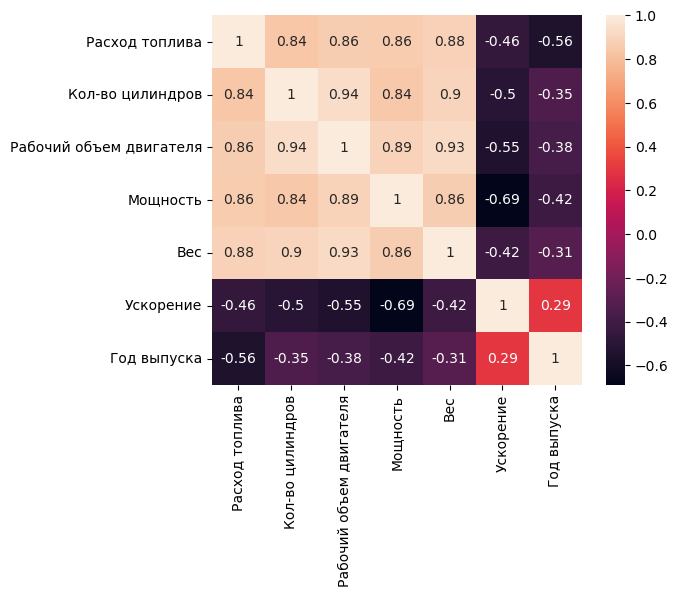

In [88]:
fig, ax = plt.subplots()

sns.heatmap(cm, annot = True, square = True)
ax.set_ylim(
    7, 0
)
plt.show()

__Вывод:__ Видим довольно сильную корреляцию >0.8 целевой переменной с весом, мощностью, обьемом двигателя, количеством цилиндров. Так же видим, что сами признаки коллинеарны. Мы будем учитывать это при построении модели.

## Построим попарную корреляцию между каждым признаком и целевой переменной

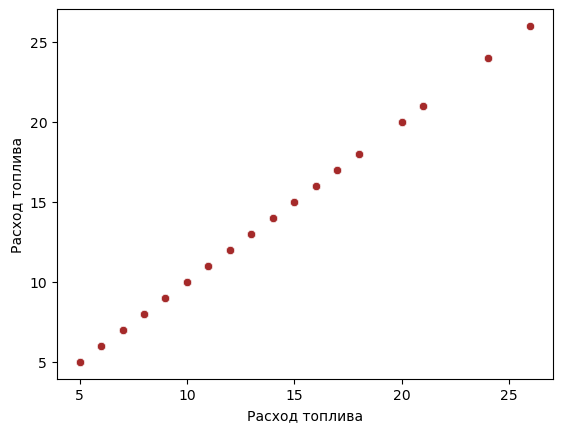

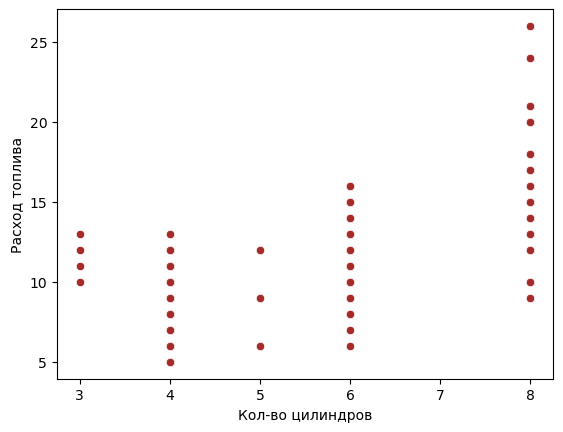

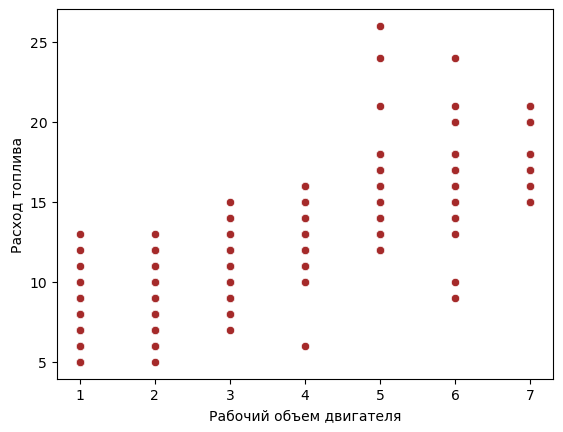

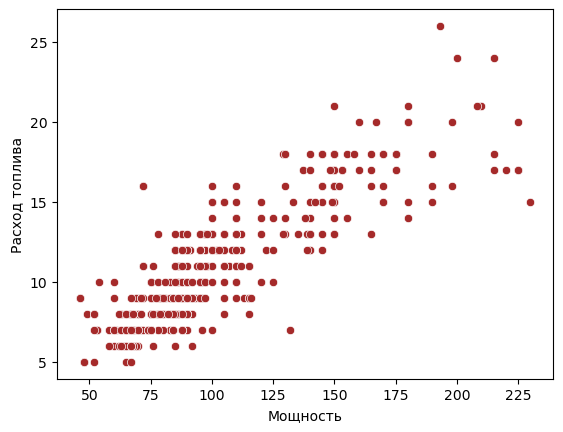

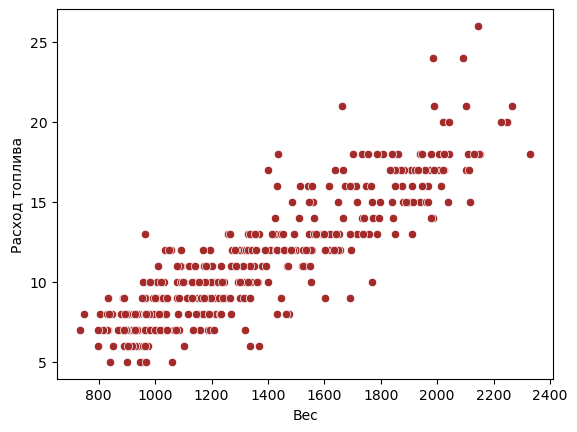

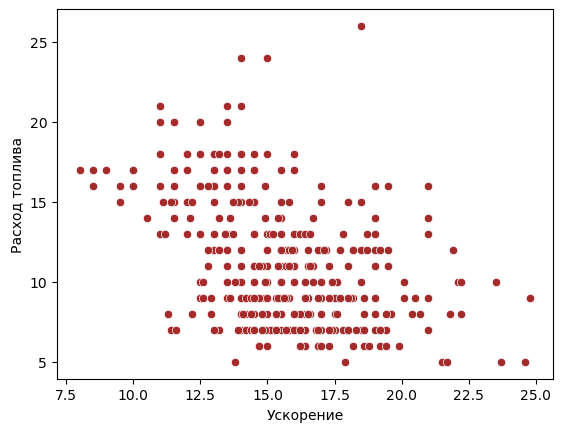

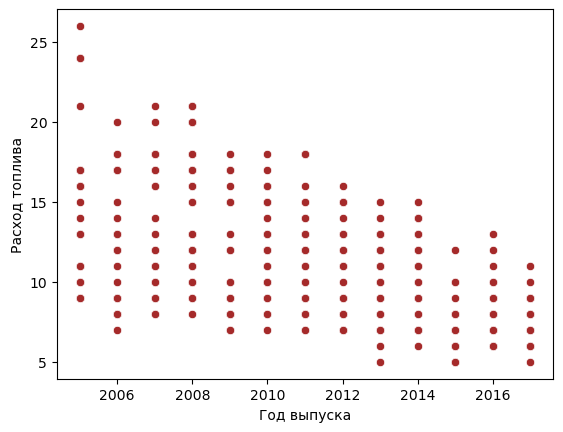

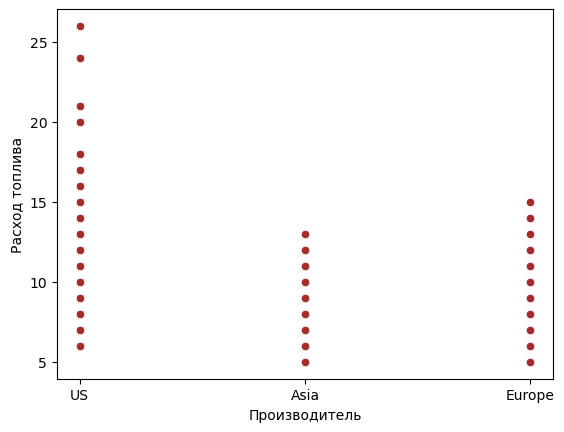

In [90]:
for col in cars.columns:
    sns.scatterplot(x = cars[col], y = cars['Расход топлива'], color = 'brown')
    plt.show()

__Вывод:__ каких-то явных выбросов нет, опять таки же мы подтвердили корреляцию, которую видели ранее

# Подготовим данные для обучения

In [91]:
cars = pd.get_dummies(cars) #преобразуем категориальные признаки

In [92]:
cars.head()

,Расход топлива,Кол-во цилиндров,Рабочий объем двигателя,Мощность,Вес,Ускорение,Год выпуска,Производитель_Asia,Производитель_Europe,Производитель_US
0,13,8,5,130.0,1589,12.0,2005,False,False,True
1,16,8,6,165.0,1675,11.5,2005,False,False,True
2,13,8,5,150.0,1559,11.0,2005,False,False,True
3,15,8,5,150.0,1557,12.0,2005,False,False,True
4,14,8,5,140.0,1564,10.5,2005,False,False,True


In [94]:
X = cars.drop('Расход топлива', axis = 1)
y = cars['Расход топлива']
#подготовили входные данные

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=0)
# разделили выборку на тестовую и тренировочную

In [97]:
#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)#обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
print(X_train_st[:5])

[[-0.8576193  -1.23609922 -0.8984236  -1.22390661  0.44574133  0.25439532
   1.95330095 -0.45149325 -1.28551249]
 [ 0.32752348  0.47332223 -0.1059203   0.54551669  0.58957333  0.52802327
  -0.51195388 -0.45149325  0.77789987]
 [-0.8576193  -0.66629207 -0.8984236  -0.91937679 -0.84874664  0.80165122
  -0.51195388 -0.45149325  0.77789987]
 [ 0.32752348 -0.09648492 -0.60783906  0.04671783  0.73340532 -0.01923264
  -0.51195388 -0.45149325  0.77789987]
 [-0.8576193  -0.66629207 -0.23800419 -0.82749279 -0.02171266 -1.11374445
   1.95330095 -0.45149325 -1.28551249]]


In [98]:
#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)
print(X_test_st[:5])

[[-0.8576193  -1.23609922 -0.76633972 -1.00863553 -0.38129265 -0.56648854
  -0.51195388 -0.45149325  0.77789987]
 [-0.8576193  -0.66629207 -0.42292162 -0.09767131  0.62553132  0.80165122
  -0.51195388 -0.45149325  0.77789987]
 [ 1.51266626  1.61293653  1.47908629  1.76626125 -0.74087264 -1.11374445
  -0.51195388 -0.45149325  0.77789987]
 [-0.8576193  -0.66629207 -1.08334104 -1.00863553 -0.30937665  1.62253508
  -0.51195388 -0.45149325  0.77789987]
 [-0.8576193  -0.66629207 -0.97767393 -0.98500821  0.87723732  1.07527918
   1.95330095 -0.45149325 -1.28551249]]


# Выбор модели

In [103]:
# Зададим список возможных моделей
models = [
    Lasso(random_state=0),
    Ridge(random_state=0),
    DecisionTreeRegressor(random_state=0),
    RandomForestRegressor(random_state=0),
    GradientBoostingRegressor(random_state=0),
]

In [104]:
# функция, которая вычисляет MAPE
def mape(y_true, y_pred):
    y_error = y_true - y_pred
    y_error_abs = [abs(i) for i in y_error]
    perc_error_abs = y_error_abs / y_true
    mape = perc_error_abs.sum() / len(y_true)
    return mape

In [105]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'MAE:{:.2f} MSE:{:.2f} MAPE:{:.2f} R2:{:.2f} '.format(
            mean_absolute_error(y_test, y_pred),
            mean_squared_error(y_test, y_pred),
            mape(y_test, y_pred),
            r2_score(y_test, y_pred),
        )
    )

In [106]:
#цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i,X_train_st,y_train,X_test_st,y_test)

Lasso(random_state=0)
MAE:1.41 MSE:3.53 MAPE:0.14 R2:0.78 
Ridge(random_state=0)
MAE:1.05 MSE:1.93 MAPE:0.09 R2:0.88 
DecisionTreeRegressor(random_state=0)
MAE:1.25 MSE:3.56 MAPE:0.11 R2:0.78 
RandomForestRegressor(random_state=0)
MAE:0.94 MSE:1.62 MAPE:0.08 R2:0.90 
GradientBoostingRegressor(random_state=0)
MAE:0.95 MSE:1.63 MAPE:0.08 R2:0.90 


__Вывод:__ побеждает модель RandomForestRegressor

# Подбор гиперпараметров

Не будем подбирать все параметры, выберем основные 

In [108]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],#Количество деревьев в ансамбле
    'max_depth': [3,5, 8, 10, None],#Максимальная глубина дерева
    'min_samples_split': [2, 5, 7], #Минимальное количество образцов для разделения узла
    'max_features': ['sqrt', 'log2']#Минимальное количество образцов в листе.
}

model = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_st, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}


__Вывод:__ Лучшие параметры: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}

# Делаем финальный предикт с лучшими параметрами и выводим метрики

In [111]:
base_model = RandomForestRegressor()

In [109]:
best_model = RandomForestRegressor(random_state=0,max_depth=8, max_features = 'sqrt',\
                                  min_samples_split = 2, n_estimators = 50)

In [110]:
make_prediction(best_model,X_train_st,y_train,X_test_st,y_test)

MAE:0.98 MSE:1.68 MAPE:0.09 R2:0.90 


In [112]:
make_prediction(base_model,X_train_st,y_train,X_test_st,y_test)

MAE:0.93 MSE:1.62 MAPE:0.08 R2:0.90 


__Вывод__:как ни странно но с базовыми параметрами модель предсказывает лучше. Чтож и такое бывает.

# Оценим важность признаков

In [113]:
importances = final_model.feature_importances_
df = pd.DataFrame()
df['Признак'] = list(X.columns)
df['Важность'] = list(importances)
print(df.sort_values(by = 'Важность', ascending = False))

                   Признак  Важность
3                      Вес  0.461402
2                 Мощность  0.242258
1  Рабочий объем двигателя  0.145227
5              Год выпуска  0.092215
4                Ускорение  0.030789
0         Кол-во цилиндров  0.024803
8         Производитель_US  0.001602
7     Производитель_Europe  0.000896
6       Производитель_Asia  0.000807


__Вывод:__ видим что больше всего расход топлива предопределяют такие параметры, как вес и мощность

# Общий вывод

Была построена модель на базе библиотеки sklearn алгоритмом RandomForestRegressor. Модель предсказывает расходы топлива в зависимости от входящих параметров машины (веса, год выпуска и т.д) 

Модель имеет следующие показатели качества: 
MAE:0.93 MSE:1.62 MAPE:0.08 R2:0.90

Более всего на расход топлива влияют такие признаки, как вес машины, ее мощность и двигатель.